# Extract and Analyze Copy Number Changes from CONGASp Results
This notebook loads CONGASp model results, extracts regions with copy number changes, and summarizes/visualizes them.

In [1]:
import sys
sys.path.append('/app')
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

## Load Results

In [9]:
# Adjust the path as needed
results_path = './congas_results.npy'  # or wherever your results are saved
bin_counts_path = './bin_counts_for_python.csv'

params = np.load(results_path, allow_pickle=True).item()
bin_counts = pd.read_csv(bin_counts_path, index_col=0)
segments = bin_counts.shape[0]

In [11]:
segments

791

## Extract Copy Number and Assignments

In [3]:
cnv_probs = params['CNV_probabilities']  # (K, segments, hidden_dim)
CNA = params['CNA']  # (K, segments)
assignment_probs_rna = params.get('assignment_probs_rna', None)
assignment_probs_atac = params.get('assignment_probs_atac', None)

## Get Most Likely Cluster Assignments

In [4]:
if assignment_probs_rna is not None:
    cluster_assignments_rna = np.argmax(assignment_probs_rna, axis=0)
else:
    cluster_assignments_rna = None
if assignment_probs_atac is not None:
    cluster_assignments_atac = np.argmax(assignment_probs_atac, axis=0)
else:
    cluster_assignments_atac = None

## Identify Segments with Copy Number Changes

In [5]:
K = CNA.shape[0]
segments_with_cnv = []
for seg_idx in range(segments):
    for cluster_idx in range(K):
        cn = CNA[cluster_idx, seg_idx]
        if cn != 2:  # Not diploid
            segments_with_cnv.append({
                'segment_idx': seg_idx,
                'cluster': cluster_idx,
                'copy_number': cn,
                'segment_name': bin_counts.index[seg_idx]
            })

cnv_df = pd.DataFrame(segments_with_cnv)
print("Segments with copy number changes:")
print(cnv_df)

Segments with copy number changes:
      segment_idx  cluster  copy_number  segment_name
0               0        1            3             0
1               1        0            1             0
2               1        1            3             0
3               1        2            3             0
4               2        0            1             0
...           ...      ...          ...           ...
1724          789        0            3             0
1725          789        1            1             0
1726          789        2            1             0
1727          790        1            1             0
1728          790        2            1             0

[1729 rows x 4 columns]


## Analyze Results by Cluster

In [6]:
for cluster_idx in range(K):
    cluster_cn = CNA[cluster_idx, :]
    print(f"\nCluster {cluster_idx}:")
    if cluster_assignments_rna is not None:
        print(f"Number of RNA cells: {np.sum(cluster_assignments_rna == cluster_idx)}")
    if cluster_assignments_atac is not None:
        print(f"Number of ATAC cells: {np.sum(cluster_assignments_atac == cluster_idx)}")
    cn_changes = cluster_cn != 2
    if np.any(cn_changes):
        print(f"Segments with CN changes: {np.sum(cn_changes)}")
        for seg_idx in np.where(cn_changes)[0]:
            cn = cluster_cn[seg_idx]
            seg_name = bin_counts.index[seg_idx]
            print(f"  {seg_name}: CN = {cn}")
    else:
        print("No CN changes detected (all segments diploid)")


Cluster 0:
Number of RNA cells: 9782
Number of ATAC cells: 3721
Segments with CN changes: 573
  0: CN = 1
  0: CN = 1
  1: CN = 1
  0: CN = 1
  1: CN = 1
  0: CN = 1
  2: CN = 1
  0: CN = 1
  0: CN = 1
  2: CN = 1
  0: CN = 1
  0: CN = 1
  0: CN = 1
  0: CN = 1
  0: CN = 3
  0: CN = 1
  0: CN = 1
  0: CN = 3
  0: CN = 1
  0: CN = 3
  0: CN = 1
  1: CN = 1
  0: CN = 1
  1: CN = 3
  0: CN = 3
  0: CN = 1
  0: CN = 3
  0: CN = 1
  0: CN = 3
  0: CN = 1
  0: CN = 1
  0: CN = 1
  0: CN = 1
  0: CN = 1
  0: CN = 1
  0: CN = 1
  0: CN = 3
  0: CN = 3
  0: CN = 1
  0: CN = 1
  0: CN = 1
  0: CN = 3
  0: CN = 1
  0: CN = 1
  0: CN = 1
  0: CN = 1
  0: CN = 3
  0: CN = 1
  1: CN = 1
  0: CN = 3
  0: CN = 1
  0: CN = 1
  0: CN = 1
  0: CN = 1
  0: CN = 1
  0: CN = 1
  0: CN = 1
  0: CN = 1
  0: CN = 3
  0: CN = 1
  0: CN = 1
  0: CN = 1
  1: CN = 1
  0: CN = 1
  0: CN = 1
  0: CN = 1
  0: CN = 1
  0: CN = 1
  0: CN = 1
  0: CN = 1
  0: CN = 1
  0: CN = 1
  0: CN = 3
  0: CN = 1
  0: CN = 1
  0: 

## Save Results

In [7]:
results = {
    'copy_numbers': CNA,
    'cluster_assignments_rna': cluster_assignments_rna,
    'cluster_assignments_atac': cluster_assignments_atac,
    'cnv_segments': cnv_df,
    'assignment_probs_rna': assignment_probs_rna,
    'assignment_probs_atac': assignment_probs_atac
}
np.save('./detailed_congas_results.npy', results)
cnv_df.to_csv('./cnv_segments.csv', index=False)

## Visualize Copy Number Changes

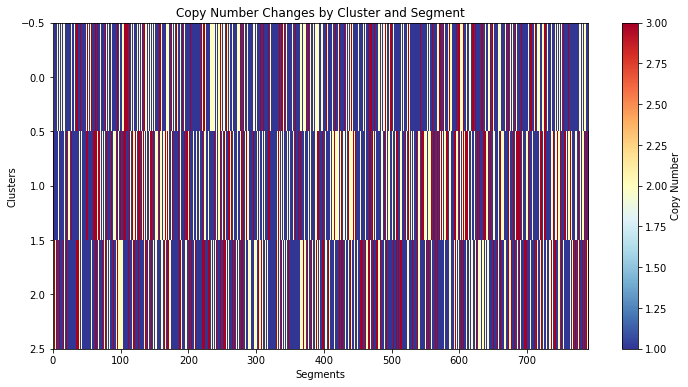

In [8]:
plt.figure(figsize=(12, 6))
plt.imshow(CNA, aspect='auto', cmap='RdYlBu_r')
plt.colorbar(label='Copy Number')
plt.xlabel('Segments')
plt.ylabel('Clusters')
plt.title('Copy Number Changes by Cluster and Segment')
plt.show()